In [1]:
import pickle
from pprint import pprint
from tqdm import tqdm
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk

from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.utils.multiclass import unique_labels

pd.set_option('display.max_colwidth', None)

# Loading data

In [2]:
questions = pd.read_csv("./data/data.csv", delimiter=";")
answers = pd.read_csv("./data/train.csv", delimiter=";")

In [3]:
data = pd.merge(questions, answers, on="ID")

In [4]:
data["Question"] = data["Question"].astype("string")

# Analyzing data

In [5]:
print(data.shape)

(30000, 3)


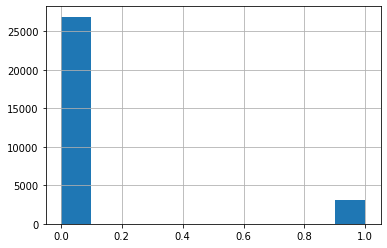

In [6]:
plt.grid(True)
plt.hist(data["Answer"])
plt.show()

In [7]:
display(data[data["Answer"] == 1].iloc[:10])

,ID,Question,Answer
1,2,Как в химии обозначается свинец?,1
5,6,Какая эра геологической истории Земли относится к настоящему времени?,1
8,9,Какой из этих мультфильмов повествует о реально существовавшей собаке?,1
20,21,"Как называется часть речи, обладающая свойствами глагола и прилагательного?",1
22,23,Когда была запущена «Википедия»?,1
41,42,Где находится яд у кобры?,1
45,46,Как зовут создателя паровой машины?,1
48,49,Сколько всего пальцев на лапах у кошек?,1
63,64,Сколько всего было выпущено серий сериала «Санта-Барбара»?,1
64,65,В каком году был поход Руси на Константинополь?,1


In [8]:
display(data[data["Answer"] == 0].iloc[:10])

,ID,Question,Answer
0,1,Как зовут лодочника на реке Стикс в древнегреческой мифологии?,0
2,3,Какой химический элемент преобладает в составе каменного угля?,0
3,4,Кто из перечисленных был пажом во времена Екатерины II?,0
4,5,Когда началась 2 мировая война?,0
6,7,Кто из животных может мурлыкать?,0
7,8,Что из перечисленного НЕ входит в национальную русскую кухню?,0
9,10,Кто написал повесть «Муму»,0
10,11,Что такое кульверт?,0
11,12,В какой воде меньше содержание примесей?,0
12,13,Сколько музыкантов в квинтете,0


In [9]:
X = data["Question"].to_numpy()
y = data["Answer"].to_numpy()

# Solving task

## Parameters

In [10]:
cv = 2
scoring = ["accuracy", "roc_auc"]
refit = "roc_auc"

In [11]:
results = {}
metrics = ["mean_test_" + score for score in scoring]

## Common functions

In [12]:
def get_results(gs):
    global results
    name = "__".join([step[0] for step in gs.estimator.steps])
    results[name] = {metric: round(gs.cv_results_[metric][gs.best_index_], 3) for metric in metrics}
    results[name] = results[name] | {"best_params": gs.best_params_}
    pprint(results[name])

In [13]:
def predict(gs, name=""):
    
    if name == "":
        name = "__".join([step[0] for step in gs.estimator.steps])
        
    questions = pd.read_csv("./data/data.csv", delimiter=";")
    test = pd.read_csv("./data/test.csv", delimiter=";")
    data = pd.merge(questions, test, on="ID")
    prediction = gs.predict_proba(list(data["Question"]))[:, 1]
    data["prediction"] = prediction
    data[["ID", "prediction"]].to_csv(f"./output/{name}.csv", index=False, header=False)

In [14]:
def save_model(gs):
    
    name = "__".join([step[0] for step in gs.estimator.steps])
    with open(f"./models/{name}.pickle", "wb") as f:
        pickle.dump(gs, f)

## Text preparation

In [15]:
def text_preprocess(x):
    #x = x[0]
    x = x.lower()
    x = re.sub(r'https*\S+', ' ', x)                           # mentions
    x = re.sub(r'@\S+', ' ', x)                                # links
    x = re.sub(r'#\S+', ' ', x)                                # hashtags
    x = re.sub(r'\'\w+', '', x)                                # ticks and the next character
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x) # punctuation
    x = re.sub(r'\w*\d+\w*', '', x)                            # numbers
    x = re.sub(r'\s{2,}', ' ', x)                              # over spaces
    x = x.replace('\xad', '')                                  # \xad
    x = x.replace('\t', '')                                    # \t
    x = x.replace('№', '')                                     # \t
    return x

In [16]:
"""
tfidfvectorizer__param_grid = {
    "tfidfvectorizer__ngram_range": [(1, 2), (1, 3), (1, 5), (1, 7)],
    "tfidfvectorizer__analyzer": ['char','word','char_wb'],
    "tfidfvectorizer__max_features": [None, 100, 1000, 5000, 10000],
    "tfidfvectorizer__preprocessor": [text_preprocess, None],
    "tfidfvectorizer__max_df": [0.25, 0.5, 0.75, 1.],
}
"""

tfidfvectorizer__param_grid = {
    "tfidfvectorizer__ngram_range": [(1, 2)],
    "tfidfvectorizer__analyzer": ['char'],
    "tfidfvectorizer__max_features": [1000],
    "tfidfvectorizer__preprocessor": [None],
    "tfidfvectorizer__max_df": [1.],
}

## TfidfVectorizer -> MostCommonClassifier

In [17]:
class MostCommonClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, sample_param="kek"):
        self.sample_param = sample_param

    def fit(self, X, y):

        self.classes_ = unique_labels(y)
        unique, counts = np.unique(y, return_counts=True)
        self.frequency = dict(zip(unique, counts))
        self.probabilities = {}
        for k, v in self.frequency.items():
            self.probabilities[k] = v / sum(self.frequency.values())

        return self
    
    def decision_function(self, X):

        res = [0] * X.shape[0]
        
        return np.array(res)

    def predict(self, X):

        res = self.decision_function(X)
        res = [1 if pred > 0.5 else 0 for pred in res]
        
        return np.array(res)
    
    def predict_proba(self, X):

        res = self.decision_function(X)
        res = [[1-pred, pred] for pred in res]
        
        return np.array(res)

In [18]:
pipeline = make_pipeline(TfidfVectorizer(), MostCommonClassifier())

param_grid = {}

gs = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, error_score="raise", n_jobs=-1)

In [19]:
gs.fit(X, y)

GridSearchCV(cv=2, error_score='raise',
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('mostcommonclassifier',
                                        MostCommonClassifier())]),
             n_jobs=-1, param_grid={}, refit='roc_auc',
             scoring=['accuracy', 'roc_auc'])

In [20]:
get_results(gs)

{'best_params': {}, 'mean_test_accuracy': 0.896, 'mean_test_roc_auc': 0.5}


In [21]:
predict(gs)

In [22]:
save_model(gs)

## TfidfVectorizer -> ProbabilityClassifier

In [23]:
class ProbabilityClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, sample_param="kek"):
        self.sample_param = sample_param

    def fit(self, X, y):

        self.classes_ = unique_labels(y)
        unique, counts = np.unique(y, return_counts=True)
        self.frequency = dict(zip(unique, counts))
        self.probabilities = {}
        for k, v in self.frequency.items():
            self.probabilities[k] = v / sum(self.frequency.values())

        return self

    def decision_function(self, X):

        res = []
        for row in X:
            res.append(np.random.choice(list(self.probabilities.keys()), p=list(self.probabilities.values())))
        
        return np.array(res)
    
    def predict(self, X):

        res = self.decision_function(X)
        res = [1 if pred > 0.5 else 0 for pred in res]
        
        return np.array(res)
    
    def predict_proba(self, X):

        res = self.decision_function(X)
        res = [[1-pred, pred] for pred in res]
        
        return np.array(res)

In [24]:
pipeline = make_pipeline(TfidfVectorizer(), ProbabilityClassifier())

param_grid = {}

gs = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, error_score="raise", n_jobs=-1)

In [25]:
gs.fit(X, y)

GridSearchCV(cv=2, error_score='raise',
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('probabilityclassifier',
                                        ProbabilityClassifier())]),
             n_jobs=-1, param_grid={}, refit='roc_auc',
             scoring=['accuracy', 'roc_auc'])

In [26]:
get_results(gs)

{'best_params': {}, 'mean_test_accuracy': 0.811, 'mean_test_roc_auc': 0.502}


In [27]:
predict(gs)

In [28]:
save_model(gs)

## TfidfVectorizer -> LogisticRegression

In [29]:
pipeline = make_pipeline(TfidfVectorizer(),
                         LogisticRegression())

"""
logisticregression__param_grid = {
    "logisticregression__class_weight": [None, "balanced"],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'logisticregression__penalty': ['l2'],
    'logisticregression__max_iter': list(range(100,800,100)),
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
"""

logisticregression__param_grid = {
    "logisticregression__class_weight": ["balanced"],
    'logisticregression__C': [1],
    'logisticregression__penalty': ['l2'],
    'logisticregression__max_iter': [100],
    'logisticregression__solver': ['newton-cg']
}

param_grid = tfidfvectorizer__param_grid | logisticregression__param_grid

gs = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, error_score="raise", n_jobs=-1, verbose=10)

In [30]:
%%time
gs.fit(X, y)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
CPU times: user 1.83 s, sys: 25.1 ms, total: 1.85 s
Wall time: 4.1 s


GridSearchCV(cv=2, error_score='raise',
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1],
                         'logisticregression__class_weight': ['balanced'],
                         'logisticregression__max_iter': [100],
                         'logisticregression__penalty': ['l2'],
                         'logisticregression__solver': ['newton-cg'],
                         'tfidfvectorizer__analyzer': ['char'],
                         'tfidfvectorizer__max_df': [1.0],
                         'tfidfvectorizer__max_features': [1000],
                         'tfidfvectorizer__ngram_range': [(1, 2)],
                         'tfidfvectorizer__preprocessor': [None]},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'], verbose=10)

In [31]:
get_results(gs)

{'best_params': {'logisticregression__C': 1,
                 'logisticregression__class_weight': 'balanced',
                 'logisticregression__max_iter': 100,
                 'logisticregression__penalty': 'l2',
                 'logisticregression__solver': 'newton-cg',
                 'tfidfvectorizer__analyzer': 'char',
                 'tfidfvectorizer__max_df': 1.0,
                 'tfidfvectorizer__max_features': 1000,
                 'tfidfvectorizer__ngram_range': (1, 2),
                 'tfidfvectorizer__preprocessor': None},
 'mean_test_accuracy': 0.69,
 'mean_test_roc_auc': 0.749}


In [32]:
gs.decision_function(X)

array([ 0.19367688,  0.89398019,  0.79259566, ...,  0.47340612,
       -0.53801877, -0.17541565])

In [33]:
gs.predict_proba(X)

array([[0.45173157, 0.54826843],
       [0.29028914, 0.70971086],
       [0.3116116 , 0.6883884 ],
       ...,
       [0.38381038, 0.61618962],
       [0.63135141, 0.36864859],
       [0.54374181, 0.45625819]])

In [34]:
predict(gs)

In [35]:
save_model(gs)

## TfidfVectorizer -> GradientBoostingClassifier

In [36]:
pipeline = make_pipeline(TfidfVectorizer(),
                         GradientBoostingClassifier())

"""
gradientboostingclassifier__param_grid = {
    "gradientboostingclassifier__learning_rate": range(0.05, 0.21. 0.05),
    "gradientboostingclassifier__n_estimators": range(20, 100, 10),
    "gradientboostingclassifier__max_depth": range(2, 8, 1),
    "gradientboostingclassifier__min_samples_split": range(150, 901, 150),
    "gradientboostingclassifier__min_samples_leaf": range(20, 41, 5),
    "gradientboostingclassifier__max_features": range(20, 101, 10),
    "gradientboostingclassifier__subsample": [0.25, 0.5, 0.75, 1.],
    "gradientboostingclassifier__random_state": [5, None],
}
"""

gradientboostingclassifier__param_grid = {
    "gradientboostingclassifier__learning_rate": [0.2],
    "gradientboostingclassifier__n_estimators": [50],
    "gradientboostingclassifier__max_depth": [5],
    "gradientboostingclassifier__min_samples_split": [750],
    "gradientboostingclassifier__min_samples_leaf": [35],
    "gradientboostingclassifier__max_features": [60],
    "gradientboostingclassifier__subsample": [1.],
    "gradientboostingclassifier__random_state": [5],
}

param_grid = tfidfvectorizer__param_grid | gradientboostingclassifier__param_grid

gs = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, error_score="raise", n_jobs=-1, verbose=10)

In [37]:
gs.fit(X, y)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2, error_score='raise',
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__learning_rate': [0.2],
                         'gradientboostingclassifier__max_depth': [5],
                         'gradientboostingclassifier__max_features': [60],
                         'gradientboostingclass...
                         'gradientboostingclassifier__n_estimators': [50],
                         'gradientboostingclassifier__random_state': [5],
                         'gradientboostingclassifier__subsample': [1.0],
                         'tfidfvectorizer__analyzer': ['char'],
                         'tfidfvectorizer__max_df': [1.0],
                         'tfidfvectorizer__max_features': [1000],
                         'tfi

In [38]:
get_results(gs)

{'best_params': {'gradientboostingclassifier__learning_rate': 0.2,
                 'gradientboostingclassifier__max_depth': 5,
                 'gradientboostingclassifier__max_features': 60,
                 'gradientboostingclassifier__min_samples_leaf': 35,
                 'gradientboostingclassifier__min_samples_split': 750,
                 'gradientboostingclassifier__n_estimators': 50,
                 'gradientboostingclassifier__random_state': 5,
                 'gradientboostingclassifier__subsample': 1.0,
                 'tfidfvectorizer__analyzer': 'char',
                 'tfidfvectorizer__max_df': 1.0,
                 'tfidfvectorizer__max_features': 1000,
                 'tfidfvectorizer__ngram_range': (1, 2),
                 'tfidfvectorizer__preprocessor': None},
 'mean_test_accuracy': 0.896,
 'mean_test_roc_auc': 0.776}


In [39]:
predict(gs)

In [40]:
save_model(gs)

## TfidfVectorizer -> AdaBoostClassifier

In [41]:
pipeline = make_pipeline(TfidfVectorizer(),
                         AdaBoostClassifier())

"""
adaboostclassifier__param_grid = {
    "adaboostclassifier__n_estimators": range(120, 151, 5),
    "adaboostclassifier__learning_rate": [1e-3, 1e-2, 1e-1, 1],
    "adaboostclassifier__random_state": [10, None],
}
"""

adaboostclassifier__param_grid = {
    "adaboostclassifier__n_estimators": [145],
    "adaboostclassifier__learning_rate": [1e-1],
    "adaboostclassifier__random_state": [None],
}

param_grid = tfidfvectorizer__param_grid | adaboostclassifier__param_grid

gs = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, error_score="raise", n_jobs=-1, verbose=10)

In [42]:
gs.fit(X, y)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2, error_score='raise',
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('adaboostclassifier',
                                        AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'adaboostclassifier__learning_rate': [0.1],
                         'adaboostclassifier__n_estimators': [145],
                         'adaboostclassifier__random_state': [None],
                         'tfidfvectorizer__analyzer': ['char'],
                         'tfidfvectorizer__max_df': [1.0],
                         'tfidfvectorizer__max_features': [1000],
                         'tfidfvectorizer__ngram_range': [(1, 2)],
                         'tfidfvectorizer__preprocessor': [None]},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'], verbose=10)

In [43]:
get_results(gs)

{'best_params': {'adaboostclassifier__learning_rate': 0.1,
                 'adaboostclassifier__n_estimators': 145,
                 'adaboostclassifier__random_state': None,
                 'tfidfvectorizer__analyzer': 'char',
                 'tfidfvectorizer__max_df': 1.0,
                 'tfidfvectorizer__max_features': 1000,
                 'tfidfvectorizer__ngram_range': (1, 2),
                 'tfidfvectorizer__preprocessor': None},
 'mean_test_accuracy': 0.896,
 'mean_test_roc_auc': 0.775}


In [44]:
predict(gs)

In [45]:
save_model(gs)

## TfidfVectorizer -> VotingClassifier

In [46]:
pipeline = Pipeline([
    ('tfidfvectorizer', TfidfVectorizer()),    
    ('votingclassifier', VotingClassifier(
        estimators=[("gradientboostingclassifier", GradientBoostingClassifier()), 
                    ("logisticregression", LogisticRegression()),
                    ("adaboostclassifier", AdaBoostClassifier())
               ]))
])

logisticregression__param_grid = {
    "votingclassifier__logisticregression__class_weight": ["balanced"],
    "votingclassifier__logisticregression__C": [1],
    "votingclassifier__logisticregression__penalty": ['l2'],
    "votingclassifier__logisticregression__max_iter": [100],
    "votingclassifier__logisticregression__solver": ['newton-cg']
}

gradientboostingclassifier__param_grid = {
    "votingclassifier__gradientboostingclassifier__learning_rate": [0.2],
    "votingclassifier__gradientboostingclassifier__n_estimators": [50],
    "votingclassifier__gradientboostingclassifier__max_depth": [5],
    "votingclassifier__gradientboostingclassifier__min_samples_split": [750],
    "votingclassifier__gradientboostingclassifier__min_samples_leaf": [35],
    "votingclassifier__gradientboostingclassifier__max_features": [60],
    "votingclassifier__gradientboostingclassifier__subsample": [1.],
    "votingclassifier__gradientboostingclassifier__random_state": [5],
}

adaboostclassifier__param_grid = {
    "votingclassifier__adaboostclassifier__n_estimators": [145],
    "votingclassifier__adaboostclassifier__learning_rate": [1e-1],
    "votingclassifier__adaboostclassifier__random_state": [None],
}

votingclassifier__param_grid = {
    "votingclassifier__voting": ["soft"],
    "votingclassifier__weights": [[1, 1, 1]],
}

param_grid = tfidfvectorizer__param_grid | votingclassifier__param_grid | logisticregression__param_grid | gradientboostingclassifier__param_grid |  adaboostclassifier__param_grid

gs = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, error_score="raise", n_jobs=-1, verbose=10)

In [47]:
gs.fit(X, y)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2, error_score='raise',
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('votingclassifier',
                                        VotingClassifier(estimators=[('gradientboostingclassifier',
                                                                      GradientBoostingClassifier()),
                                                                     ('logisticregression',
                                                                      LogisticRegression()),
                                                                     ('adaboostclassifier',
                                                                      AdaBoostClassifier())]))]),
             n_jobs=-1,
             param_grid={'tfidfvectorizer__analyz...
                         'votingclassifier__logisticregression__class_weight': ['balanced'],
                         'votingclassifier__logisticregression__max_iter': 

In [48]:
get_results(gs)

{'best_params': {'tfidfvectorizer__analyzer': 'char',
                 'tfidfvectorizer__max_df': 1.0,
                 'tfidfvectorizer__max_features': 1000,
                 'tfidfvectorizer__ngram_range': (1, 2),
                 'tfidfvectorizer__preprocessor': None,
                 'votingclassifier__adaboostclassifier__learning_rate': 0.1,
                 'votingclassifier__adaboostclassifier__n_estimators': 145,
                 'votingclassifier__adaboostclassifier__random_state': None,
                 'votingclassifier__gradientboostingclassifier__learning_rate': 0.2,
                 'votingclassifier__gradientboostingclassifier__max_depth': 5,
                 'votingclassifier__gradientboostingclassifier__max_features': 60,
                 'votingclassifier__gradientboostingclassifier__min_samples_leaf': 35,
                 'votingclassifier__gradientboostingclassifier__min_samples_split': 750,
                 'votingclassifier__gradientboostingclassifier__n_estimator

In [49]:
predict(gs)

In [50]:
save_model(gs)

# Results

In [51]:
info = pd.DataFrame.from_dict(results, orient="index").sort_values(by="mean_test_roc_auc", ascending=False)
display(info)

,mean_test_accuracy,mean_test_roc_auc,best_params
tfidfvectorizer__gradientboostingclassifier,0.896,0.776,"{'gradientboostingclassifier__learning_rate': 0.2, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__max_features': 60, 'gradientboostingclassifier__min_samples_leaf': 35, 'gradientboostingclassifier__min_samples_split': 750, 'gradientboostingclassifier__n_estimators': 50, 'gradientboostingclassifier__random_state': 5, 'gradientboostingclassifier__subsample': 1.0, 'tfidfvectorizer__analyzer': 'char', 'tfidfvectorizer__max_df': 1.0, 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__preprocessor': None}"
tfidfvectorizer__adaboostclassifier,0.896,0.775,"{'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 145, 'adaboostclassifier__random_state': None, 'tfidfvectorizer__analyzer': 'char', 'tfidfvectorizer__max_df': 1.0, 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__preprocessor': None}"
tfidfvectorizer__votingclassifier,0.888,0.775,"{'tfidfvectorizer__analyzer': 'char', 'tfidfvectorizer__max_df': 1.0, 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__preprocessor': None, 'votingclassifier__adaboostclassifier__learning_rate': 0.1, 'votingclassifier__adaboostclassifier__n_estimators': 145, 'votingclassifier__adaboostclassifier__random_state': None, 'votingclassifier__gradientboostingclassifier__learning_rate': 0.2, 'votingclassifier__gradientboostingclassifier__max_depth': 5, 'votingclassifier__gradientboostingclassifier__max_features': 60, 'votingclassifier__gradientboostingclassifier__min_samples_leaf': 35, 'votingclassifier__gradientboostingclassifier__min_samples_split': 750, 'votingclassifier__gradientboostingclassifier__n_estimators': 50, 'votingclassifier__gradientboostingclassifier__random_state': 5, 'votingclassifier__gradientboostingclassifier__subsample': 1.0, 'votingclassifier__logisticregression__C': 1, 'votingclassifier__logisticregression__class_weight': 'balanced', 'votingclassifier__logisticregression__max_iter': 100, 'votingclassifier__logisticregression__penalty': 'l2', 'votingclassifier__logisticregression__solver': 'newton-cg', 'votingclassifier__voting': 'soft', 'votingclassifier__weights': [1, 1, 1]}"
tfidfvectorizer__logisticregression,0.690,0.749,"{'logisticregression__C': 1, 'logisticregression__class_weight': 'balanced', 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg', 'tfidfvectorizer__analyzer': 'char', 'tfidfvectorizer__max_df': 1.0, 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__preprocessor': None}"
tfidfvectorizer__probabilityclassifier,0.811,0.502,{}
tfidfvectorizer__mostcommonclassifier,0.896,0.500,{}


# Uploading solution

## Preprocessing